###### 20 November 2018, by Jeroen van Lidth de Jeude - [NETWORKS](http://networks.imtlucca.it/) -  [IMT School for Advanced Studies Lucca](https://www.imtlucca.it/jeroen.vanlidth)
# Detecting Core-Periphery Structures by Surprise
This notebook provides the code to detect bimodular structures as core-periphery and bipartite ones, with the **bimodular surprise** as proposed in the paper : *["Detecting Core-Periphery Structures by Surprise" - Jeroen van Lidth de Jeude, Guido Caldarelli and Tiziano Squartini (10/10/2018)](https://arxiv.org/abs/1810.04717)*

![arXiv article](./Images/arxiv_article2.png )

## Bimodular Network Structures
This method can both detect core-periphery structures and bipartite ones.

![bimodulars](./Images/bimodular_structures.png )

### Bimodular Surprise
Bimodular surprise is detects significant structures by comparing the connectivity in different areas of the graph. It uses a hypergeometric distribution to evaluate bimodular graph partitions.
\begin{equation}
S_\parallel\equiv\sum_{i\geq l_c^*}\sum_{j\geq l_{cp}^*}\frac{\binom{V_c}{i} \binom{V_{cp}}{j} \binom{V-(V_c+V_{cp})}{L-(i+j)}}{\binom{V}{L}}
\end{equation}
where $V=N(N-1)$ is the volume of the network, coinciding with the total number of nodes pairs, $L$ is the total number of links and $l^*$ is the observed number of intracluster links (i.e. *within* the individuated communities). The index $c$ labels the core part and the index $cp$ labels the core-periphery part; whenever considering bipartite networks, the core-periphery portion will be assumed to indicate the inter-layer portion.
These three types of links are visualised below for the core-periphery case.

![types_of_links](./Images/types_of_links.png )

# Code
The code consists of the calculation of the distribution and the search heuristic which is to find the network partition which minimises this value. 

### Python and Packages
This code runs on Python 3.5 or any higher version.
The following Python packages are required for execution. Please make sure these are installed and updated:
on your operating system's terminal:
    - `pip install networkx`
    - or upgrading: `pip install --upgrade networkx`


In [1]:
from scipy.special import comb
import numpy as np
import networkx as nx
from numba import jit  # numba is a package to speed up certain simple bits of code

# For diplaying figures within the notebook we require: MatPlotLib
import matplotlib 
import matplotlib.pyplot as plt
%matplotlib inline

### PACO optimizing algorithm
The following chunks contain the algorithm for the *bimodular surprise* evaluation and optimization. If you think this code seems awfully long to just evaluate and minimize a distribution function, thats not a weird observation. However, for computational speed and the precision of binomial coefficients we introduced some tricks. The simple code of the bimodular surprise can actually be found as the last function below here: `evaluate_real_surprise`.

In [2]:
@jit
def logMultiHyperProbability(p, p_c, p_x, l, l_c, l_x):
    '''Evaluation of logarithmic hypergeometric distribution'''
    logH = logC(p_c, l_c) + logC(p_x, l_x) + logC(p - p_c - p_x, l-l_c-l_x) - logC(p, l)
    return logH

@jit
def logC2(n, k):
    if (k == n):
        x = 0
    else:
        t = n - k 
        if(t < k):
            t = k
        x = sumRange(t+1, n) - sumFactorial(n - t);
    return x

@jit
def sumRange(xmin, xmax):
    csum = 0
    for i in range(xmin,xmax+1):
        csum += np.log10(i)
    return csum

@jit
def sumFactorial(n):
    csum = 0
    if n > 1:
        for i in range(2,n+1):
            csum += np.log10(i)
    return csum

@jit
def sumLogProbabilities2(nextP, P, logP):
    logP += np.log1p(nextP / P)
    return logP

@jit
def sumLogProbabilities(nextLogP, logP):
    if nextLogP == 0:
        stop = True
    else:
        stop = False
        if nextLogP > logP:
            common = nextLogP
            diffExponent = logP - common
        else:
            common = logP
            diffExponent = nextLogP - common
        
        logP = common + ((np.log10(1 + 10**diffExponent)) / np.log10(10))
    
        if (nextLogP - logP) > -4:
            stop = True
            
    return logP, stop

@jit
def logC(n, k):
    if k == n: 
        return 0
    elif (n > 1000) & (k > 1000): # Stirling's binomial coeff approximation
        return logStirFac(n) - logStirFac(k) - logStirFac(n-k)
    else:
        t = n - k
        if t < k:
            t = k
        logC = sumRange(t + 1, n) - sumFactorial(n - t)
        return logC
    
@jit
def logStirFac(n):
    if n <= 1:
        return 1.0
    else:
        return -n + n*np.log10(n) + np.log10(n*(1 + 4.0*n*(1.0 + 2.0*n)))/6.0 + np.log10(np.pi)/2.0   
    
@jit
def logBin(n, k):
    return logStirFac(n) - logStirFac(k) - logStirFac(n - k)

@jit
def surprise_bipartite_logsum(p, p_c, p_x, l, l_c, l_x):
    stop = False
    first_loop_break = False

    min_l_p = min(l, p_c+p_x)
    
    logP = logMultiHyperProbability(p, p_c, p_x, l, l_c, l_x)
    for l_c_loop in range(l_c, min_l_p+1):
        for l_x_loop in range(l_x, min_l_p+1 - l_c_loop):
            if (l_c_loop == l_c) & (l_x_loop == l_x):
                continue
            nextLogP = logMultiHyperProbability(p, p_c, p_x, l, l_c_loop, l_x_loop)
            [logP, stop] = sumLogProbabilities(nextLogP, logP)
    
            if stop:
                first_loop_break = True 
                break  
        if first_loop_break:
            break 
    
    return -logP       

@jit
def calculate_surprise_logsum(adjacency_matrix, core_nodes, periphery_nodes, is_directed=True):
    
    core_nodes = set(core_nodes)
    periphery_nodes = set(periphery_nodes)
        
    if (len(core_nodes) <= 1) | (len(periphery_nodes) <= 1): #not enough core/periphery nodes: bin. coef. = 0
        return 1
    assert np.sum(adjacency_matrix.diagonal()) == 0, 'Adjacency diagonal not zero: illegal self loops'    
    
    if is_directed == True:
        p_c = len(core_nodes) * (len(core_nodes)- 1) 
        p_x = len(core_nodes) * len(periphery_nodes) * 2
        #p_p = len(periphery_nodes) * (len(periphery_nodes) - 1)
        l_c = np.sum(adjacency_matrix[np.ix_(list(core_nodes), list(core_nodes))] > 0)             
        l_x = np.sum(adjacency_matrix[np.ix_(list(periphery_nodes), list(core_nodes))] > 0) + (
                        np.sum(adjacency_matrix[np.ix_(list(core_nodes), list(periphery_nodes))] > 0) )    
        l = np.sum(adjacency_matrix > 0) 
        n = len(core_nodes) + len(periphery_nodes)
        p = n*(n-1)
    else: # is_directed == False : UNDIRECTED
        adjacency_matrix = np.triu(adjacency_matrix)
        p_c = int(len(core_nodes) * (len(core_nodes)- 1) /2)
        p_x = len(core_nodes) * len(periphery_nodes) 
        #p_p = len(periphery_nodes) * (len(periphery_nodes) - 1)
        l_c = np.sum(adjacency_matrix[np.ix_(list(core_nodes), list(core_nodes))] > 0)             
        l_x = np.sum(adjacency_matrix[np.ix_(list(periphery_nodes), list(core_nodes))] > 0) + (
                        np.sum(adjacency_matrix[np.ix_(list(core_nodes), list(periphery_nodes))] > 0) )    
        l = np.sum(adjacency_matrix > 0) 
        n = len(core_nodes) + len(periphery_nodes)
        p = int(n*(n-1) / 2)
    
    if (p_c + p_x) < (l_c+l_x):
        return 0
    surprise = surprise_bipartite_logsum(p, p_c, p_x, l, l_c, l_x)
    return surprise 

def remove_isolated_nodes(adj):
    zero_in_degree = np.where(np.sum(adj,0) == 0)[0]
    zero_out_degree = np.where(np.sum(adj,1) == 0)[0]
    zero_degree_nodes = np.array(list(set(zero_in_degree) & set(zero_out_degree)))
    degree_nodes = np.array(list(set(np.arange(len(adj))) - set(zero_degree_nodes)))
    
    if len(zero_degree_nodes)>0:
        adj_new = adj[np.ix_(list(degree_nodes), list(degree_nodes))] 
    else:
        adj_new = adj
    
    return adj_new, zero_degree_nodes


def insert_isolated_nodes(zero_degree_nodes, cluster_assignment):
    for node in zero_degree_nodes:
        cluster_assignment = np.insert(cluster_assignment, node, 1)
    return cluster_assignment


def calculate_surprise(adjacency_matrix, cluster_assignment, is_directed=True):
    core_nodes = np.where(cluster_assignment == 0)[0]
    periphery_nodes = np.where(cluster_assignment == 1)[0]
        
    if (len(core_nodes) <= 1) | (len(periphery_nodes) <= 1): #not enough core/periphery nodes: bin. coef. = 0
        return 1
    assert np.sum(adjacency_matrix.diagonal()) == 0, 'Adjacency diagonal not zero: illegal self loops'    
    
    if is_directed == True:
        return calculate_surprise_logsum(adjacency_matrix, core_nodes, periphery_nodes, is_directed=True)
    else: # is_directed == False : UNDIRECTED
        return calculate_surprise_logsum(adjacency_matrix, core_nodes, periphery_nodes, is_directed=False)

    return 1
    

def jaccard_sorted_edges(adjacency_matrix):
    G = nx.from_numpy_matrix(adjacency_matrix)
    jacc = nx.jaccard_coefficient(G, ebunch=G.edges())
    jacc_array = []
    for u, v, p in jacc:
        jacc_array += [[u,v,p]]
    jacc_array = np.array(jacc_array)
    jacc_array = jacc_array[jacc_array[:,2].argsort()][::-1]
    sorted_edges = jacc_array[:,0:2]
    sorted_edges = sorted_edges.astype(np.int)
    return sorted_edges 

@jit
def calculate_z_motifs(adjacency):
    adj = adjacency.copy()
    G = nx.from_numpy_array(adj)
    # make adjacency symetric/undirected
    adj2 = adj  + np.transpose(adj)
    adj = adj2.astype(bool).astype(int)

    z_motifs = np.zeros(len(G.edges()))
    nodes = G.nodes()
    for index,[i,j] in enumerate(G.edges()):
        for k in nodes:
            if k not in [i,j]:
                for l in nodes:
                    if (l not in [i,j,k]) & (l > k):
                        #z_motifs[index] += adj[i,k]*adj[k,l]*adj[j,l]
                        z_motifs[index] += adj[i,k]*adj[j,l]
    return z_motifs, np.array(G.edges())


def sort_edges_z_motif(adj):    
    z_motifs, edges_array = calculate_z_motifs(adj)
    sort_indices = np.argsort(z_motifs)
    sorted_edges = edges_array[sort_indices[::-1]]
    return sorted_edges


def flip_random_group(a, flip_n_nodes=2):
    if (sum(a==0) <= flip_n_nodes+1):
        a[np.random.choice(np.where(a==1)[0], replace=False, size=flip_n_nodes)] = 0
        return a
    elif (sum(a==1) <= flip_n_nodes+1):
        a[np.random.choice(np.where(a==0)[0], replace=False, size=flip_n_nodes)] = 1
        return a
    elif np.random.rand() < 0.5:
        a[np.random.choice(np.where(a==0)[0], replace=False, size=flip_n_nodes)] = 1
    else:
        a[np.random.choice(np.where(a==1)[0], replace=False, size=flip_n_nodes)] = 0
    return a


def correct_partition_numbering(adjacency_matrix, cluster_assignment):
    core_nodes = np.where(cluster_assignment == 0)[0]
    periphery_nodes = np.where(cluster_assignment == 1)[0]
    l_core = np.sum(adjacency_matrix[np.ix_(list(core_nodes), list(core_nodes))] > 0)   
    l_periphery = np.sum(adjacency_matrix[np.ix_(list(periphery_nodes), list(periphery_nodes))] > 0)   
    core_density = l_core / (len(core_nodes)*(len(core_nodes)-1))
    periphery_density = l_periphery / (len(periphery_nodes)*(len(periphery_nodes)-1))

    if periphery_density > core_density:
        cluster_assignment_new = 1- cluster_assignment
        return cluster_assignment_new
    return cluster_assignment


def minimize_surprise_paco(adjacency_matrix, num_sim, is_directed=True, sort_method='zmotif'):
    
    surprise = 0
    cluster_assignment = np.ones(len(adjacency_matrix), dtype=int)
    degrees = np.sum(adjacency_matrix,0) + np.sum(adjacency_matrix,1)
    cluster_assignment[degrees.argsort()[-3:]] = 0

    degrees = np.vstack((np.arange(len(degrees)),degrees))
    degrees = degrees[:,degrees[1,:].argsort()[::-1]]
    nodes_degree_sorted = degrees[0,:]
    
    if sort_method == 'zmotif':
        E_sorted = sort_edges_z_motif(adjacency_matrix)
    elif sort_method == 'jaccard':
        E_sorted = jaccard_sorted_edges(adjacency_matrix)
    else:
        assert False, '`sort_method` must be "zmotif" or "jaccard"'
    
    for sim in np.arange(num_sim):
        for [u,v] in E_sorted:
            cluster_assignment_temp1 = cluster_assignment.copy()
            cluster_assignment_temp2 = cluster_assignment.copy()
            if cluster_assignment[u] != cluster_assignment[v]:
                cluster_assignment_temp1[v] = cluster_assignment[u]
                cluster_assignment_temp2[u] = cluster_assignment[v]

                surprise_temp = calculate_surprise(adjacency_matrix, cluster_assignment_temp1, is_directed)
                if (surprise_temp >= surprise):
                    cluster_assignment = cluster_assignment_temp1.copy()
                    surprise = surprise_temp
                    
                surprise_temp = calculate_surprise(adjacency_matrix, cluster_assignment_temp2, is_directed)
                if (surprise_temp >= surprise):
                    cluster_assignment = cluster_assignment_temp2.copy()
                    surprise = surprise_temp
                    
            else: # cluster_assignment is the same
                cluster_assignment_temp1[v] = 1 - cluster_assignment[v] #invert assignment
                cluster_assignment_temp2[u] = 1 - cluster_assignment[u]

                surprise_temp = calculate_surprise(adjacency_matrix, cluster_assignment_temp1, is_directed)
                if (surprise_temp >= surprise):
                    cluster_assignment = cluster_assignment_temp1.copy()
                    surprise = surprise_temp
                    
                surprise_temp = calculate_surprise(adjacency_matrix, cluster_assignment_temp2, is_directed)
                if (surprise_temp >= surprise):
                    cluster_assignment = cluster_assignment_temp2.copy()
                    surprise = surprise_temp
            #print(surprise)
            if surprise == 0:
                print('zero surprise reached')
                break
        
        # Group flipping
        for i in np.arange(100):
            cluster_assignment_temp = flip_random_group(cluster_assignment.copy(), flip_n_nodes=1)
            surprise_temp = calculate_surprise(adjacency_matrix, cluster_assignment_temp, is_directed)
            if (surprise_temp >= surprise):
                cluster_assignment = cluster_assignment_temp.copy()
                surprise = surprise_temp

            cluster_assignment_temp = flip_random_group(cluster_assignment.copy(), flip_n_nodes=2)
            surprise_temp = calculate_surprise(adjacency_matrix, cluster_assignment_temp, is_directed)
            if (surprise_temp >= surprise):
                cluster_assignment = cluster_assignment_temp.copy()
                surprise = surprise_temp

            cluster_assignment_temp = flip_random_group(cluster_assignment.copy(), flip_n_nodes=3)
            surprise_temp = calculate_surprise(adjacency_matrix, cluster_assignment_temp, is_directed)
            if (surprise_temp >= surprise):
                cluster_assignment = cluster_assignment_temp.copy()
                surprise = surprise_temp
                
            cluster_assignment_temp = flip_random_group(cluster_assignment.copy(), flip_n_nodes=4)
            surprise_temp = calculate_surprise(adjacency_matrix, cluster_assignment_temp, is_directed)
            if (surprise_temp >= surprise):
                cluster_assignment = cluster_assignment_temp.copy()
                surprise = surprise_temp
            
    cluster_assignment = correct_partition_numbering(adjacency_matrix, cluster_assignment)            
    return cluster_assignment, surprise


def run_surprise(G, num_sim=10, is_directed=True, sort_method='zmotif'):
    """Running the PACO optimization algoritm for cp detection.
    This fucntion takes as argument either a numpy adjacency matrix or a networkx graph. 

        Args:
            G: [numpy.array or networkx.Graph] the adjacency matrix 
            num_sim: [int] number of heuristic runs minimal is 1
            is_directed: [boolean] indicator if graph is directed or not
            sort_methos: ['zmotif' or 'jaccard'] the method used to sort the edges

        Returns:
            numpy.array vector is node assignment and numpy.float significance value

    """
    if (type(G) == nx.classes.graph.Graph) | (type(G) == nx.classes.digraph.DiGraph):
        adj = nx.to_numpy_array(G)
        np.fill_diagonal(adj, 0)
    else: #G is an adjacency
        adj = G
    
    [cluster_assignment, surprise] = minimize_surprise_paco(adj, num_sim, is_directed, sort_method)
    
    # evaluate the actual surprise value, not the logsum version
    #real_surprise = evaluate_real_surprise(adj, cluster_assignment, is_directed=is_directed)
    real_surprise = 10**(-surprise)
  
    return cluster_assignment, real_surprise

@jit
def surprise_bimodular(p, p_c, p_x, l, l_c, l_x):    
    min_l_p = min(l, p_c+p_x)
    
    surprise = 0
    for l_c_loop in range(l_c, min_l_p+1):
        for l_x_loop in range(l_x, min_l_p+1 - l_c_loop):
            surprise += comb(p_c, l_c_loop, exact=1) * comb(p_x, l_x_loop, exact=1) * comb(p - p_c - p_x, l - l_c_loop - l_x_loop, exact=1) / comb(p, l, exact=1)
    return surprise


def evaluate_real_surprise(adjacency_matrix, partition, is_directed=True):
    core_nodes = np.where(partition == 0)[0]
    periphery_nodes = np.where(partition == 1)[0]
    core_nodes = set(core_nodes)
    periphery_nodes = set(periphery_nodes)
        
    if (len(core_nodes) <= 1) | (len(periphery_nodes) <= 1): #not enough core/periphery nodes: bin. coef. = 0
        return 1
    assert np.sum(adjacency_matrix.diagonal()) == 0, 'Adjacency diagonal not zero: illegal self loops'    
    
    if is_directed == True:
        p_c = len(core_nodes) * (len(core_nodes)- 1) 
        p_x = len(core_nodes) * len(periphery_nodes) * 2
        #p_p = len(periphery_nodes) * (len(periphery_nodes) - 1)
        l_c = np.sum(adjacency_matrix[np.ix_(list(core_nodes), list(core_nodes))] > 0)             
        l_x = np.sum(adjacency_matrix[np.ix_(list(periphery_nodes), list(core_nodes))] > 0) + (
                        np.sum(adjacency_matrix[np.ix_(list(core_nodes), list(periphery_nodes))] > 0) )    
        l = np.sum(adjacency_matrix > 0) 
        n = len(core_nodes) + len(periphery_nodes)
        p = n*(n-1)
    else: # is_directed == False : UNDIRECTED
        adjacency_matrix = np.triu(adjacency_matrix)
        p_c = int(len(core_nodes) * (len(core_nodes)- 1) /2)
        p_x = len(core_nodes) * len(periphery_nodes) 
        #p_p = len(periphery_nodes) * (len(periphery_nodes) - 1)
        l_c = np.sum(adjacency_matrix[np.ix_(list(core_nodes), list(core_nodes))] > 0)             
        l_x = np.sum(adjacency_matrix[np.ix_(list(periphery_nodes), list(core_nodes))] > 0) + (
                        np.sum(adjacency_matrix[np.ix_(list(core_nodes), list(periphery_nodes))] > 0) )    
        l = np.sum(adjacency_matrix > 0) 
        n = len(core_nodes) + len(periphery_nodes)
        p = int(n*(n-1) / 2)
    
    return surprise_bimodular(p, p_c, p_x, l, l_c, l_x)

# Running the Algorithm
Running the algorithm is as simple as calling the function `run_surprise` with as argument the *adjacency matrix* of the graph or a *NetworkX graph*. The adjacency matrix should be supplied in the numpy.array format. See also the examples.

The two output variables of the algorithm are: a numpy.array vector detailing the *node assignment*, and a float value of the *significance* of the partition. 

## Example - Karate Club
In this example we analyze the core-periphery structure of the infamous Zachary Karate club graph: an undirected, unweighted social interactions graph. For more details on this classic network community detection dataset see: [Zachary’s Zachary karate club](https://petterhol.me/2018/01/28/zacharys-zachary-karate-club/) 

In [3]:
G_karate = nx.karate_club_graph() # Loading the graph from the NetworkX package

# Run the bimodular surprise algorithm
partitioning, significance = run_surprise(G=G_karate, is_directed=False)

In [4]:
partitioning

array([0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0])

The variable `partitioning` now shows the node assingment found by bimodular surprise. Nodes with value zero are in the core, nodes with value 1 in the periphery. In this case the first three nodes and the last two nodes are in the core. The order of the nodes in the partitioning is the same as the ordering of the nodes in the adjacency matrix/the ordering of the NetworkX graph.nodes(). 

In [5]:
significance

1.6313419062282474e-22

The variable `significance` stores the significance value (p-value) of the found partition. In general a partition with a significance value < 0.01 can be considered significant.

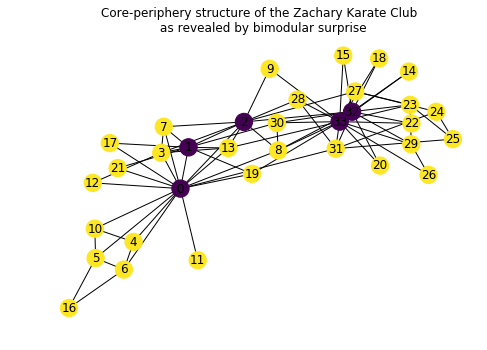

In [6]:
nx.draw(G=G_karate, node_color=partitioning, with_labels=True)
_ = plt.title('Core-periphery structure of the Zachary Karate Club \n as revealed by bimodular surprise')

## Example - Loading an external file
In this example we load an external file. Graph files (gml, gexf, etc.) are easiest loaded using NetworkX, adjacency matrices (csv, txt, etc.) are usually imported using Numpy. Here we load a artificial core-periphery like structure from a csv file. 

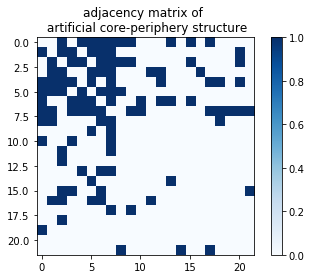

In [7]:
# Loading a csv adjacency matrix from the working directory (same as where notebook is saved)
adj = np.loadtxt('./Data/artificial_core-periphery_matrix.csv', delimiter=',')
adj = adj > 0 # Force binary
adj = adj.astype(int) # Force integers

plt.imshow(adj, cmap='Blues')
plt.colorbar()
_ = plt.title('adjacency matrix of \n artificial core-periphery structure')

In [8]:
# The adjacency matrix can be directly given as an input to the function
partitioning, significance = run_surprise(G=adj, is_directed=True)

print(significance, partitioning)

9.81263527586384e-30 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


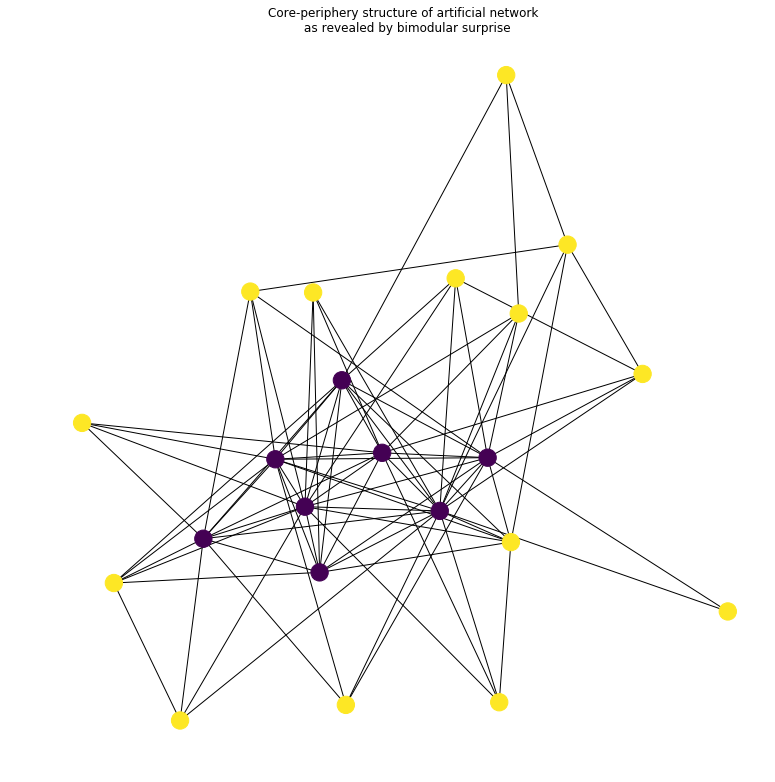

In [9]:
plt.figure(figsize=(10,10))
G_external_adj = nx.from_numpy_array(adj)  # Create NetworkX graph for visualisation
nx.draw(G=G_external_adj, node_color=partitioning, with_labels=False)
_ = plt.title('Core-periphery structure of artificial network \n as revealed by bimodular surprise')

The bimodular surprise identifies the planted core correctly, see the visualised adjacency matrix of the data. 

### Useful links
This work was done within the [NETWORKS](http://networks.imtlucca.it/) research group at [IMT School for Advanced Studies Lucca](http://www.imtlucca.it/) with [Tiziano Squartini](https://www.imtlucca.it/tiziano.squartini) and [Guido Caldarelli](http://www.guidocaldarelli.com/). 

The search heuristic was adapted from [Carlo Nicolini'](https://github.com/CarloNicolini/paco) work. The surprise method is based on the [surprise](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0024195) for community detection. 

For more information, please check out our [paper](https://arxiv.org/abs/1810.04717). 